In [ ]:
# See if torchmetrics exists, if not, install it
try:
    import torchmetrics, mlxtend

except:
    !pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 KB 20.5 MB/s eta 0:00:00


In [ ]:
import torchvision
import torch
from torch import nn
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.utils.data import DataLoader
from torchmetrics.classification import Accuracy

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


print(torch.__version__)
print(torchvision.__version__)

1.13.1+cu116
0.14.1+cu116


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor(),
    target_transform=None,
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to data/FashionMNIST/raw



In [ ]:
class_names = train_data.classes
num_classes = len(class_names)
len(class_names), class_names
new_class_names = [i for i in range(len(class_names))]
new_class_names

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:
# get the classes
class_names = train_data.classes
len(class_names), class_names

(10,
 ['T-shirt/top',
  'Trouser',
  'Pullover',
  'Dress',
  'Coat',
  'Sandal',
  'Shirt',
  'Sneaker',
  'Bag',
  'Ankle boot'])

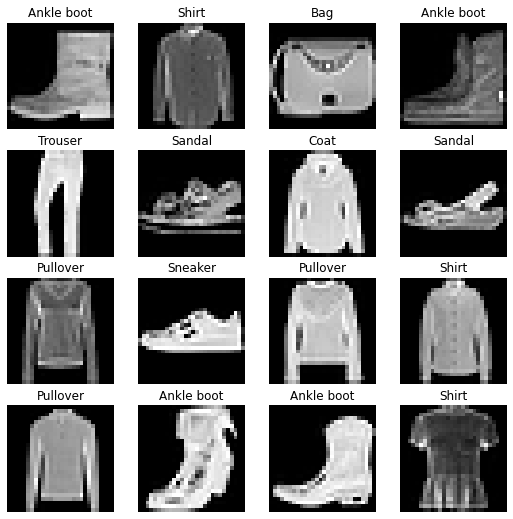

In [ ]:

# plot some images
torch.manual_seed(42)
fig = plt.figure(figsize=(9,9));
rows, cols = 4, 4
for i in range(1, rows*cols+1):
  random_idx = torch.randint(0, len(train_data), size=[1]).item()
  img, label = train_data[random_idx]
  fig.add_subplot(rows, cols, i)
  plt.imshow(img.squeeze(), cmap='gray');
  plt.title(class_names[label]);
  plt.axis(False);

In [ ]:
# create dataloaders
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset=train_data,
                             batch_size=BATCH_SIZE,
                             shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)


In [ ]:
print(f"Dataloaders: {train_dataloader, test_dataloader}")
print(f"lenght of trainloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"lenght of testloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x7f7f71e6b790>, <torch.utils.data.dataloader.DataLoader object at 0x7f7f71e7db80>)
lenght of trainloader: 1875 batches of 32
lenght of testloader: 313 batches of 32


In [ ]:
class FashionMNIST_model(nn.Module):

    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1),# options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*7*7, 
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.block_1(x)
        # print(f'output shape of conv_block_1: {x.shape}')
        x = self.block_2(x)
        # print(f'output shape of conv_block_2: {x.shape}')
        x = self.classifier(x)
        # print(f'output shape of classifier: {x.shape}')
        return x

In [ ]:
# training loop
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
  
    train_loss, train_acc = 0, 0
    for batch, (X, y) in enumerate(data_loader):
        # Send data to GPU
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(target=y,
                                 preds=y_pred.argmax(dim=1)) # Go from logits -> pred labels

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

    # Calculate loss and accuracy per epoch and print out what's happening
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}")


# testing loop
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.eval() # put model in eval mode
    # Turn on inference context manager
    with torch.inference_mode(): 
        for X, y in data_loader:
            # Send data to GPU
            X, y = X.to(device), y.to(device)
            
            # 1. Forward pass
            test_pred = model(X)
            
            # 2. Calculate loss and accuracy
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(target=y,
                preds=test_pred.argmax(dim=1) # Go from logits -> pred labels
            )
        
        # Adjust metrics and print out
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}\n")

In [ ]:
# get model results dictionary
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn,
               device=device):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:

            X, y = X.to(device), y.to(device)
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(target=y, 
                                preds=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()}

In [ ]:
torch.manual_seed(42)
model = FashionMNIST_model(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

model

FashionMNIST_model(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)
accuracy_fn = Accuracy(task='multiclass', num_classes=num_classes).to(device)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)


EPOCHS = 20
for epoch in tqdm(range(1,EPOCHS+1)):
  print(f"epoch: {epoch}\n------")

  train_step(model=model,
             data_loader=train_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             optimizer=optimizer,
             device=device)
  
  test_step(model=model,
             data_loader=test_dataloader,
             loss_fn=loss_fn,
             accuracy_fn=accuracy_fn,
             device=device)




  0%|          | 0/20 [00:00<?, ?it/s]

epoch: 1
------
Train loss: 0.59822 | Train accuracy: 0.78
Test loss: 0.41033 | Test accuracy: 0.85

epoch: 2
------
Train loss: 0.36438 | Train accuracy: 0.87
Test loss: 0.35412 | Test accuracy: 0.87

epoch: 3
------
Train loss: 0.32579 | Train accuracy: 0.88
Test loss: 0.32919 | Test accuracy: 0.88

epoch: 4
------
Train loss: 0.30345 | Train accuracy: 0.89
Test loss: 0.32142 | Test accuracy: 0.88

epoch: 5
------
Train loss: 0.28793 | Train accuracy: 0.90
Test loss: 0.29594 | Test accuracy: 0.90

epoch: 6
------
Train loss: 0.27729 | Train accuracy: 0.90
Test loss: 0.31416 | Test accuracy: 0.89

epoch: 7
------
Train loss: 0.27149 | Train accuracy: 0.90
Test loss: 0.32410 | Test accuracy: 0.88

epoch: 8
------
Train loss: 0.26517 | Train accuracy: 0.90
Test loss: 0.31086 | Test accuracy: 0.89

epoch: 9
------
Train loss: 0.25847 | Train accuracy: 0.91
Test loss: 0.29463 | Test accuracy: 0.89

epoch: 10
------
Train loss: 0.26173 | Train accuracy: 0.90
Test loss: 0.29492 | Test accur

In [ ]:
# Get model results
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    device=device,
)

model_results

{'model_name': 'FashionMNIST_model',
 'model_loss': 0.29917770624160767,
 'model_acc': 0.8941693305969238}

In [ ]:
y_preds=[]
model.eval()
with torch.inference_mode():
  for batch, (X, y) in tqdm(enumerate(test_dataloader)):
    # Make sure data on right device
    X, y = X.to(device), y.to(device)
    # Forward pass
    y_pred_logits = model(X)
    # Logits -> Pred probs -> Pred label
    y_pred_labels = torch.argmax(torch.softmax(y_pred_logits, dim=1), dim=1)
    # Append the labels to the preds list
    y_preds.append(y_pred_labels)
  y_preds=torch.cat(y_preds).cpu()
len(y_preds) 

0it [00:00, ?it/s]

10000

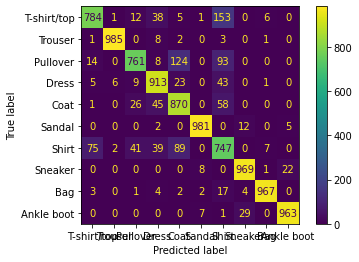

In [ ]:
cm = confusion_matrix(y_true=test_data.targets,
                      y_pred=y_preds,
                      labels=new_class_names)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=class_names)
disp.plot()
plt.show()

In [ ]:
from genericpath import exists
from pathlib import Path

MODEL_PATH = Path('models')
MODEL_PATH.mkdir(parents=True,
                   exist_ok=True)

MODEL_NAME = "pytorch_computer_vision_model_FASHIONMNIST.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME

# save model_state_dict
print(f"saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(),
           f=MODEL_SAVE_PATH)

saving model to: models/pytorch_computer_vision_model_FASHIONMNIST.pth
